# Import necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking
import matplotlib.pyplot as plt

# Load and preprocess the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load the CSV data into a pandas DataFrame
# df = pd.read_csv('/content/drive/MyDrive/Stock price predict(Saify)/cleand_SANDP500.csv')

df = pd.read_csv('/content/drive/MyDrive/DDP/diabetes.csv')

# Sort the DataFrame by the "Date" column in ascending order
df.sort_values(by='Outcome', inplace=True)

# Display the first few rows of the data to get an initial view
print(df.head())

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
383            1       90             62             18       59  25.1   
465            0      124             56             13      105  21.8   
466            0       74             52             10       36  27.8   
467            0       97             64             36      100  36.8   
469            6      154             78             41      140  46.1   

     DiabetesPedigreeFunction  Age  Outcome  
383                     1.268   25        0  
465                     0.452   21        0  
466                     0.269   22        0  
467                     0.600   25        0  
469                     0.571   27        0  


# Data normalization

In [6]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close'] = scaler.fit_transform(np.array(df['Outcome']).reshape(-1, 1))
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Close
383,1,90,62,18,59,25.1,1.268,25,0,0.0
465,0,124,56,13,105,21.8,0.452,21,0,0.0
466,0,74,52,10,36,27.8,0.269,22,0,0.0
467,0,97,64,36,100,36.8,0.600,25,0,0.0
469,6,154,78,41,140,46.1,0.571,27,0,0.0


# Create sequences for LSTM

In [7]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

# Set sequence length
seq_length = 10

# Create sequences
sequences = create_sequences(df['Close'].values, seq_length)

# Split the data into input (X) and output (y)
X = np.array([seq[:-1] for seq in sequences])  # Exclude the last element from each sequence
y = np.array([seq[-1] for seq in sequences])   # Take the last element from each sequence

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
print("Shape of X_train:", X_train.shape)


Shape of X_train: (607, 9)


In [9]:
print("Shape of X_train:", X_test.shape)

Shape of X_train: (152, 9)


# Build and train the LSTM model with 10 epoch

In [10]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(40, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(Masking(mask_value=0.2))  # Assuming input data has 3 features
model.add(LSTM(units=10, return_sequences = False))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=16)


Epoch 1/10
38/38 [==============================] - 5s 17ms/step - loss: 0.2121
Epoch 2/10
38/38 [==============================] - 1s 14ms/step - loss: 0.0197
Epoch 3/10
38/38 [==============================] - 1s 14ms/step - loss: 0.0054
Epoch 4/10
38/38 [==============================] - 1s 14ms/step - loss: 0.0053
Epoch 5/10
38/38 [==============================] - 1s 14ms/step - loss: 0.0053
Epoch 6/10
38/38 [==============================] - 1s 14ms/step - loss: 0.0052
Epoch 7/10
38/38 [==============================] - 1s 14ms/step - loss: 0.0052
Epoch 8/10
38/38 [==============================] - 0s 11ms/step - loss: 0.0051
Epoch 9/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0051
Epoch 10/10
38/38 [==============================] - 0s 9ms/step - loss: 0.0051


In [11]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Invert the scaling for predictions
predictions = scaler.inverse_transform(predictions)

# Reshape y_test to 2D
y_test = y_test.reshape(-1, 1)
# Invert the scaling for actual values
y_test_actual = scaler.inverse_transform(y_test)

# Compare predictions with actual values
compare_df = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': predictions.flatten()})
print(compare_df)


5/5 [==============================] - 1s 7ms/step - loss: 0.0077
Mean Squared Error on Test Set: 0.007684782147407532
5/5 [==============================] - 1s 8ms/step
     Actual  Predicted
0       0.0   0.013820
1       1.0   1.011489
2       0.0   0.013820
3       1.0   1.011489
4       0.0   0.013820
..      ...        ...
147     1.0   1.011489
148     0.0   0.013820
149     0.0   0.013820
150     0.0   0.013820
151     0.0   0.013820

[152 rows x 2 columns]


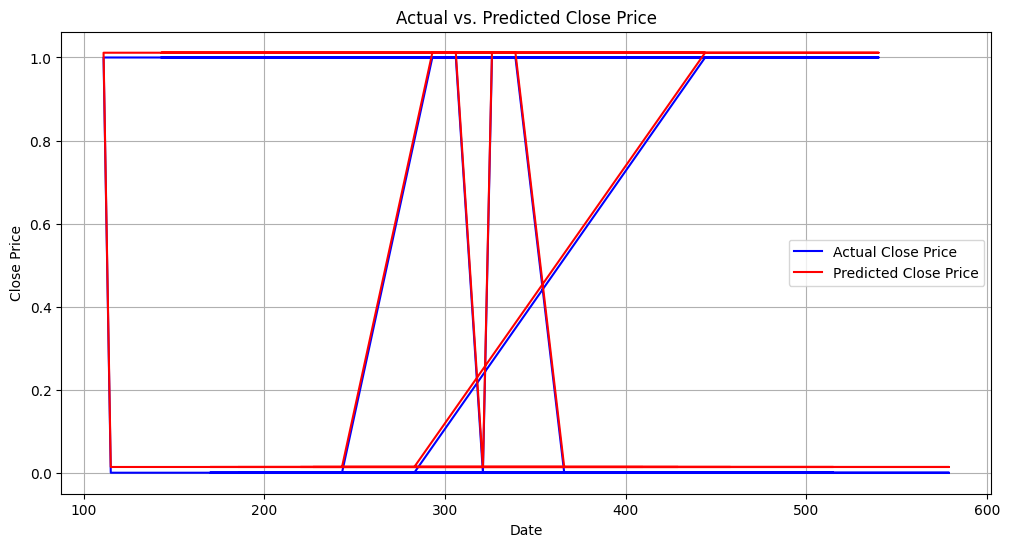

In [12]:
# Plot a subset of data (every 5th data point)
subset_interval = 5

plt.figure(figsize=(12, 6))

# Plot the actual and predicted values
plt.plot(df.index[-len(y_test):][::subset_interval], y_test_actual.flatten()[::subset_interval], label='Actual Close Price', color='blue')
plt.plot(df.index[-len(y_test):][::subset_interval], predictions.flatten()[::subset_interval], label='Predicted Close Price', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price')
plt.legend()
plt.grid(True)
plt.show()


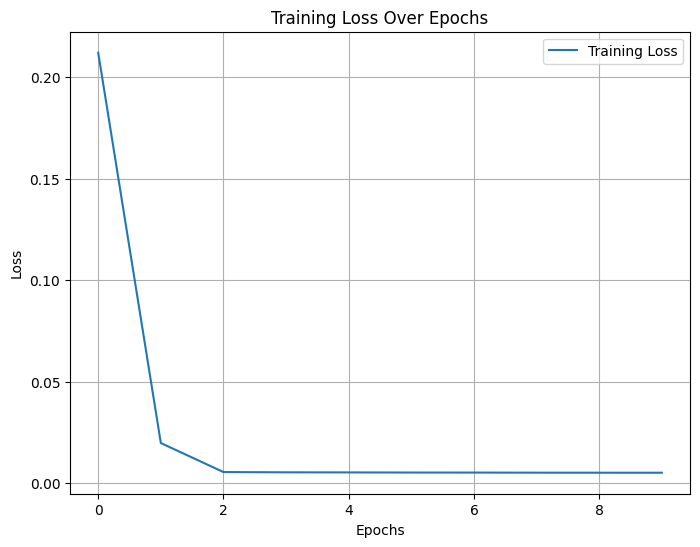

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 40)             6720      
                                                                 
 lstm_1 (LSTM)               (None, 10)                2040      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 8771 (34.26 KB)
Trainable params: 8771 (34.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Build and train the LSTM model 15 epoch

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=40, activation="relu",return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', )

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=16)


Epoch 1/15
286/286 [==============================] - 7s 13ms/step - loss: 0.0073
Epoch 2/15
286/286 [==============================] - 3s 10ms/step - loss: 1.7176e-04
Epoch 3/15
286/286 [==============================] - 2s 9ms/step - loss: 1.5645e-04
Epoch 4/15
286/286 [==============================] - 2s 9ms/step - loss: 1.5294e-04
Epoch 5/15
286/286 [==============================] - 3s 9ms/step - loss: 1.5520e-04
Epoch 6/15
286/286 [==============================] - 3s 11ms/step - loss: 1.5671e-04
Epoch 7/15
286/286 [==============================] - 4s 13ms/step - loss: 1.5489e-04
Epoch 8/15
286/286 [==============================] - 3s 9ms/step - loss: 1.5385e-04
Epoch 9/15
286/286 [==============================] - 3s 9ms/step - loss: 1.4979e-04
Epoch 10/15
286/286 [==============================] - 3s 9ms/step - loss: 1.4808e-04
Epoch 11/15
286/286 [==============================] - 3s 9ms/step - loss: 1.4923e-04
Epoch 12/15
286/286 [==============================] - 4s 13ms/

In [ ]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Invert the scaling for predictions
predictions = scaler.inverse_transform(predictions)

# Reshape y_test to 2D
y_test = y_test.reshape(-1, 1)
# Invert the scaling for actual values
y_test_actual = scaler.inverse_transform(y_test)

# Compare predictions with actual values
compare_df = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': predictions.flatten()})
print(compare_df)


36/36 [==============================] - 1s 4ms/step - loss: 1.1326e-04
Mean Squared Error on Test Set: 0.00011325679224682972
36/36 [==============================] - 1s 3ms/step
       Actual    Predicted
0     1433.27  1466.435425
1     1829.83  1782.333374
2      942.30   931.637085
3     3719.89  3854.181885
4     4521.54  4491.721680
...       ...          ...
1138  1122.41  1131.794678
1139  1101.39  1113.927246
1140  1413.58  1414.934326
1141  1165.81  1153.315186
1142  2790.37  2696.446045

[1143 rows x 2 columns]


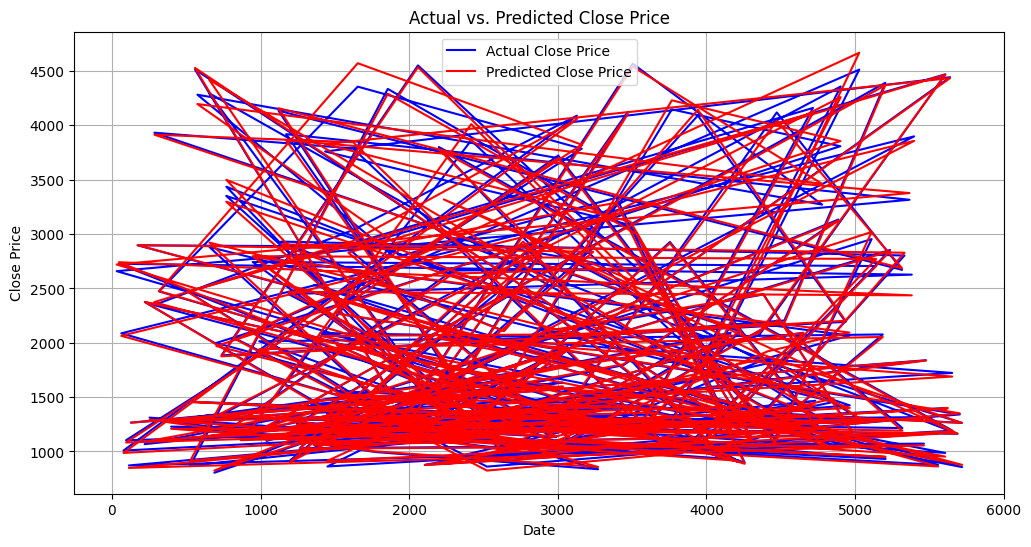

In [ ]:
# Plot a subset of data (every 5th data point)
subset_interval = 5

plt.figure(figsize=(12, 6))

# Plot the actual and predicted values
plt.plot(df.index[-len(y_test):][::subset_interval], y_test_actual.flatten()[::subset_interval], label='Actual Close Price', color='blue')
plt.plot(df.index[-len(y_test):][::subset_interval], predictions.flatten()[::subset_interval], label='Predicted Close Price', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price')
plt.legend()
plt.grid(True)
plt.show()


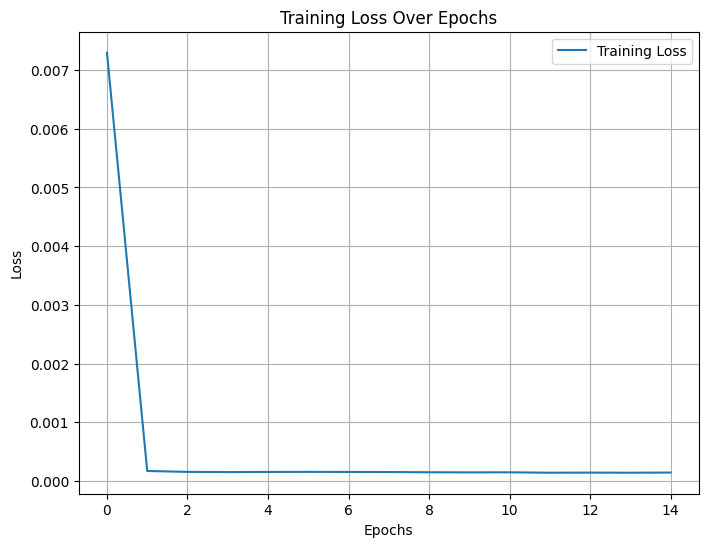

In [ ]:
# tr_loss = history.history['loss']
# index_loss = np.argmin(tr_loss)
# val_lowest = tr_loss[index_loss]
# loss_label = f'best epoch= {str(index_loss + 1)}'

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
# plt.scatter(index_loss + 1, val_lowest, s = 100, c = 'red', label = loss_label)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Build and train the LSTM model with 20 epoch

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=40, activation="relu",return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=10))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', )

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16)


Epoch 1/20
286/286 [==============================] - 7s 12ms/step - loss: 0.0075
Epoch 2/20
286/286 [==============================] - 2s 9ms/step - loss: 1.7028e-04
Epoch 3/20
286/286 [==============================] - 2s 9ms/step - loss: 1.6411e-04
Epoch 4/20
286/286 [==============================] - 2s 9ms/step - loss: 1.5489e-04
Epoch 5/20
286/286 [==============================] - 3s 10ms/step - loss: 1.7088e-04
Epoch 6/20
286/286 [==============================] - 4s 13ms/step - loss: 1.5063e-04
Epoch 7/20
286/286 [==============================] - 3s 10ms/step - loss: 1.5588e-04
Epoch 8/20
286/286 [==============================] - 2s 9ms/step - loss: 1.4478e-04
Epoch 9/20
286/286 [==============================] - 3s 9ms/step - loss: 1.5297e-04
Epoch 10/20
286/286 [==============================] - 3s 9ms/step - loss: 1.5286e-04
Epoch 11/20
286/286 [==============================] - 3s 11ms/step - loss: 1.5805e-04
Epoch 12/20
286/286 [==============================] - 4s 13ms

In [ ]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Invert the scaling for predictions
predictions = scaler.inverse_transform(predictions)

# Reshape y_test to 2D
y_test = y_test.reshape(-1, 1)
# Invert the scaling for actual values
y_test_actual = scaler.inverse_transform(y_test)

# Compare predictions with actual values
compare_df = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': predictions.flatten()})
print(compare_df)


36/36 [==============================] - 1s 4ms/step - loss: 1.0729e-04
Mean Squared Error on Test Set: 0.00010729066707426682
36/36 [==============================] - 1s 3ms/step
       Actual    Predicted
0     1433.27  1450.844849
1     1829.83  1777.087891
2      942.30   913.535889
3     3719.89  3821.422852
4     4521.54  4454.617188
...       ...          ...
1138  1122.41  1118.641235
1139  1101.39  1098.390991
1140  1413.58  1403.168335
1141  1165.81  1141.920166
1142  2790.37  2685.566162

[1143 rows x 2 columns]


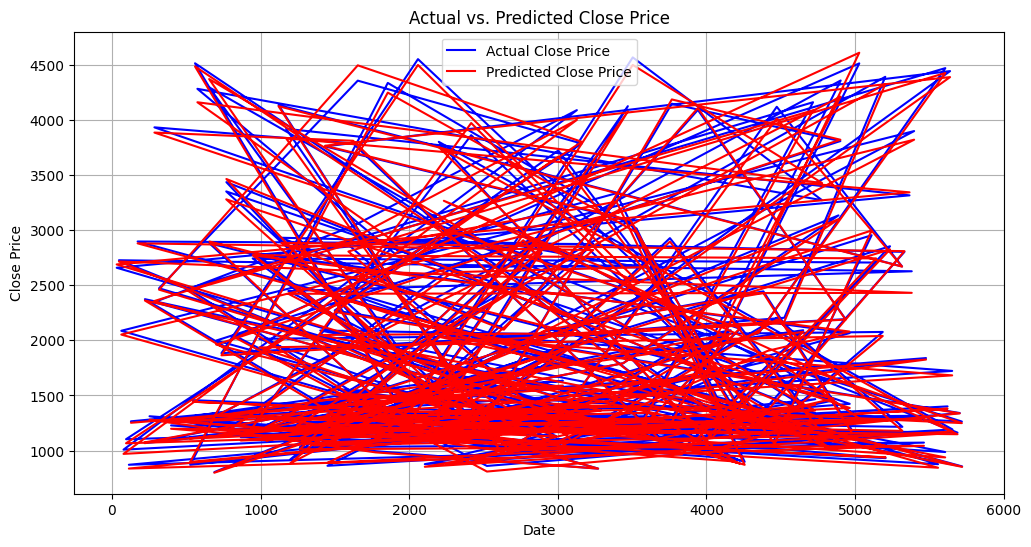

In [ ]:
# Plot a subset of data (every 5th data point)
subset_interval = 5

plt.figure(figsize=(12, 6))

# Plot the actual and predicted values
plt.plot(df.index[-len(y_test):][::subset_interval], y_test_actual.flatten()[::subset_interval], label='Actual Close Price', color='blue')
plt.plot(df.index[-len(y_test):][::subset_interval], predictions.flatten()[::subset_interval], label='Predicted Close Price', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price')
plt.legend()
plt.grid(True)
plt.show()


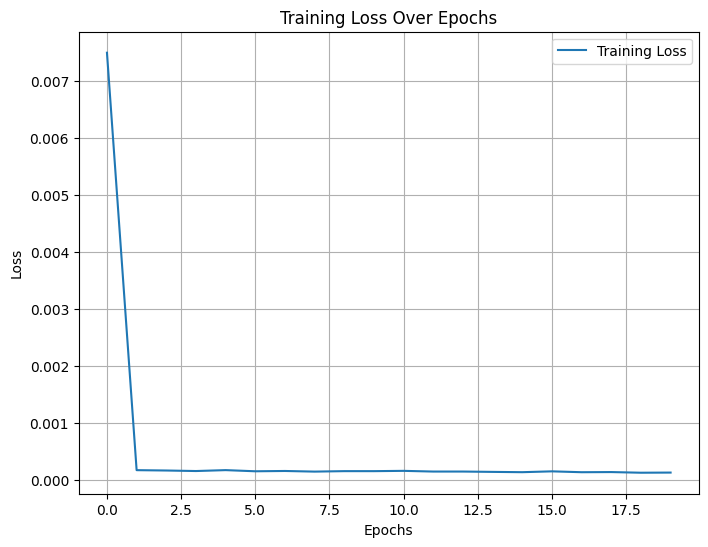

In [ ]:
# tr_loss = history.history['loss']
# index_loss = np.argmin(tr_loss)
# val_lowest = tr_loss[index_loss]
# loss_label = f'best epoch= {str(index_loss + 1)}'

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
# plt.scatter(index_loss + 1, val_lowest, s = 100, c = 'red', label = loss_label)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Build and train the LSTM model with 25 epoch

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=40, activation="relu",return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=10))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', )

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=16)


Epoch 1/25
286/286 [==============================] - 7s 10ms/step - loss: 0.0072
Epoch 2/25
286/286 [==============================] - 3s 9ms/step - loss: 1.4295e-04
Epoch 3/25
286/286 [==============================] - 3s 9ms/step - loss: 1.3207e-04
Epoch 4/25
286/286 [==============================] - 2s 9ms/step - loss: 1.3975e-04
Epoch 5/25
286/286 [==============================] - 3s 12ms/step - loss: 1.2952e-04
Epoch 6/25
286/286 [==============================] - 3s 11ms/step - loss: 1.3013e-04
Epoch 7/25
286/286 [==============================] - 3s 9ms/step - loss: 1.3400e-04
Epoch 8/25
286/286 [==============================] - 2s 9ms/step - loss: 1.3024e-04
Epoch 9/25
286/286 [==============================] - 2s 9ms/step - loss: 1.2130e-04
Epoch 10/25
286/286 [==============================] - 3s 11ms/step - loss: 1.4084e-04
Epoch 11/25
286/286 [==============================] - 3s 12ms/step - loss: 1.2099e-04
Epoch 12/25
286/286 [==============================] - 3s 9ms/

In [ ]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Invert the scaling for predictions
predictions = scaler.inverse_transform(predictions)

# Reshape y_test to 2D
y_test = y_test.reshape(-1, 1)
# Invert the scaling for actual values
y_test_actual = scaler.inverse_transform(y_test)

# Compare predictions with actual values
compare_df = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': predictions.flatten()})
print(compare_df)


36/36 [==============================] - 1s 4ms/step - loss: 6.1738e-05
Mean Squared Error on Test Set: 6.17375917499885e-05
36/36 [==============================] - 1s 5ms/step
       Actual    Predicted
0     1433.27  1459.160645
1     1829.83  1800.314209
2      942.30   926.425842
3     3719.89  3823.234375
4     4521.54  4469.641602
...       ...          ...
1138  1122.41  1128.736938
1139  1101.39  1106.964844
1140  1413.58  1419.495239
1141  1165.81  1153.132568
1142  2790.37  2727.018555

[1143 rows x 2 columns]


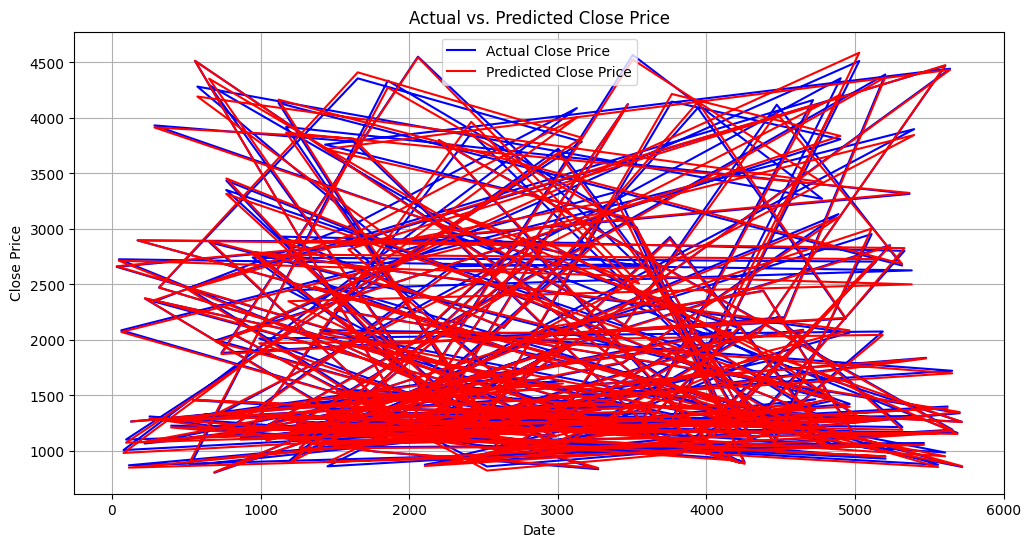

In [ ]:
# Plot a subset of data (every 5th data point)
subset_interval = 5

plt.figure(figsize=(12, 6))

# Plot the actual and predicted values
plt.plot(df.index[-len(y_test):][::subset_interval], y_test_actual.flatten()[::subset_interval], label='Actual Close Price', color='blue')
plt.plot(df.index[-len(y_test):][::subset_interval], predictions.flatten()[::subset_interval], label='Predicted Close Price', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price')
plt.legend()
plt.grid(True)
plt.show()


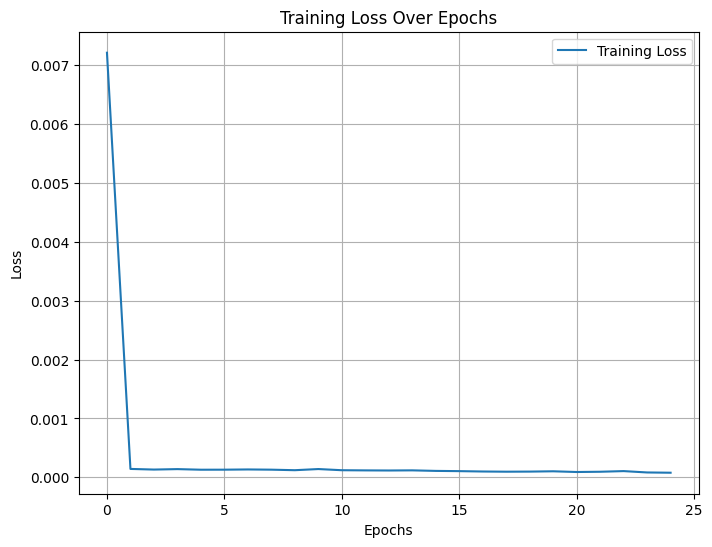

In [ ]:
# tr_loss = history.history['loss']
# index_loss = np.argmin(tr_loss)
# val_lowest = tr_loss[index_loss]
# loss_label = f'best epoch= {str(index_loss + 1)}'

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
# plt.scatter(index_loss + 1, val_lowest, s = 100, c = 'red', label = loss_label)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Build and train the LSTM model with 30 epoch

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=40, activation="relu",return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=10))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', )

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=16)


Epoch 1/30
286/286 [==============================] - 6s 9ms/step - loss: 0.0055
Epoch 2/30
286/286 [==============================] - 3s 9ms/step - loss: 1.4689e-04
Epoch 3/30
286/286 [==============================] - 3s 10ms/step - loss: 1.5056e-04
Epoch 4/30
286/286 [==============================] - 4s 13ms/step - loss: 1.4905e-04
Epoch 5/30
286/286 [==============================] - 3s 9ms/step - loss: 1.5736e-04
Epoch 6/30
286/286 [==============================] - 3s 9ms/step - loss: 1.3464e-04
Epoch 7/30
286/286 [==============================] - 3s 9ms/step - loss: 1.4606e-04
Epoch 8/30
286/286 [==============================] - 3s 10ms/step - loss: 1.3349e-04
Epoch 9/30
286/286 [==============================] - 4s 13ms/step - loss: 1.4689e-04
Epoch 10/30
286/286 [==============================] - 3s 9ms/step - loss: 1.2841e-04
Epoch 11/30
286/286 [==============================] - 3s 9ms/step - loss: 1.2652e-04
Epoch 12/30
286/286 [==============================] - 3s 9ms/s

In [ ]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Invert the scaling for predictions
predictions = scaler.inverse_transform(predictions)

# Reshape y_test to 2D
y_test = y_test.reshape(-1, 1)
# Invert the scaling for actual values
y_test_actual = scaler.inverse_transform(y_test)

# Compare predictions with actual values
compare_df = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': predictions.flatten()})
print(compare_df)


36/36 [==============================] - 1s 3ms/step - loss: 1.5931e-04
Mean Squared Error on Test Set: 0.00015930809604469687
36/36 [==============================] - 1s 3ms/step
       Actual    Predicted
0     1433.27  1491.267090
1     1829.83  1838.987427
2      942.30   952.800110
3     3719.89  3901.609863
4     4521.54  4546.544434
...       ...          ...
1138  1122.41  1159.218628
1139  1101.39  1136.817017
1140  1413.58  1451.784180
1141  1165.81  1183.896240
1142  2790.37  2790.184326

[1143 rows x 2 columns]


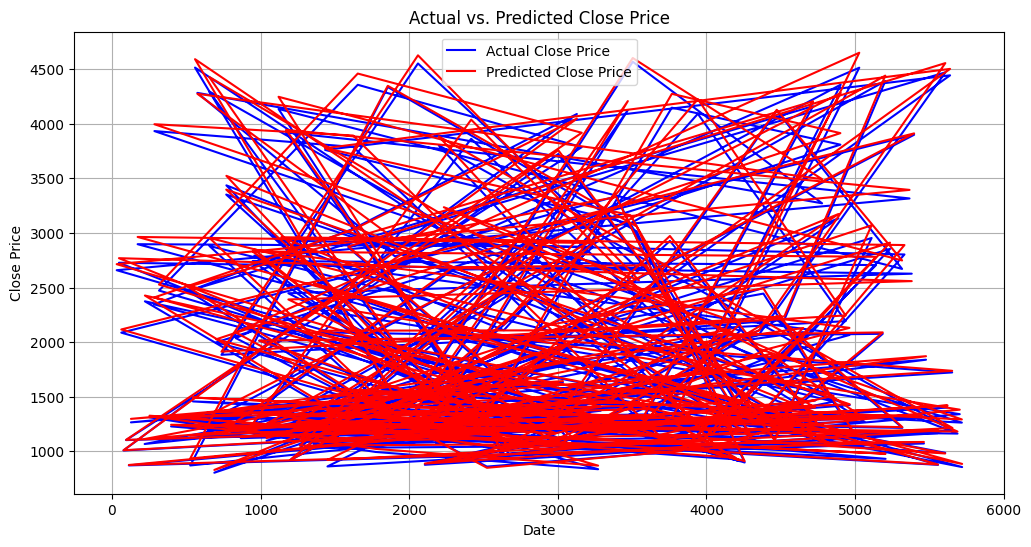

In [ ]:
# Plot a subset of data (every 5th data point)
subset_interval = 5

plt.figure(figsize=(12, 6))

# Plot the actual and predicted values
plt.plot(df.index[-len(y_test):][::subset_interval], y_test_actual.flatten()[::subset_interval], label='Actual Close Price', color='blue')
plt.plot(df.index[-len(y_test):][::subset_interval], predictions.flatten()[::subset_interval], label='Predicted Close Price', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price')
plt.legend()
plt.grid(True)
plt.show()


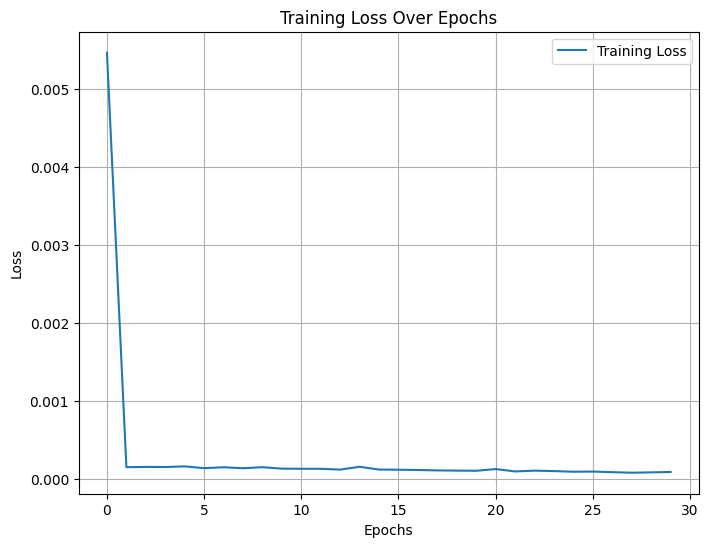

In [ ]:
# tr_loss = history.history['loss']
# index_loss = np.argmin(tr_loss)
# val_lowest = tr_loss[index_loss]
# loss_label = f'best epoch= {str(index_loss + 1)}'

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
# plt.scatter(index_loss + 1, val_lowest, s = 100, c = 'red', label = loss_label)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()